In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install torchsummary
from torchsummary import summary
from sklearn.preprocessing import OneHotEncoder
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['mitbih_test.csv', 'ptbdb_normal.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv']


In [2]:
df = pd.read_csv("../input/mitbih_train.csv", header=None)
df2 = pd.read_csv("../input/mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [3]:
x = df.iloc[:,:-1].values
y = df.iloc[:,187:188].values.astype(int)

In [4]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

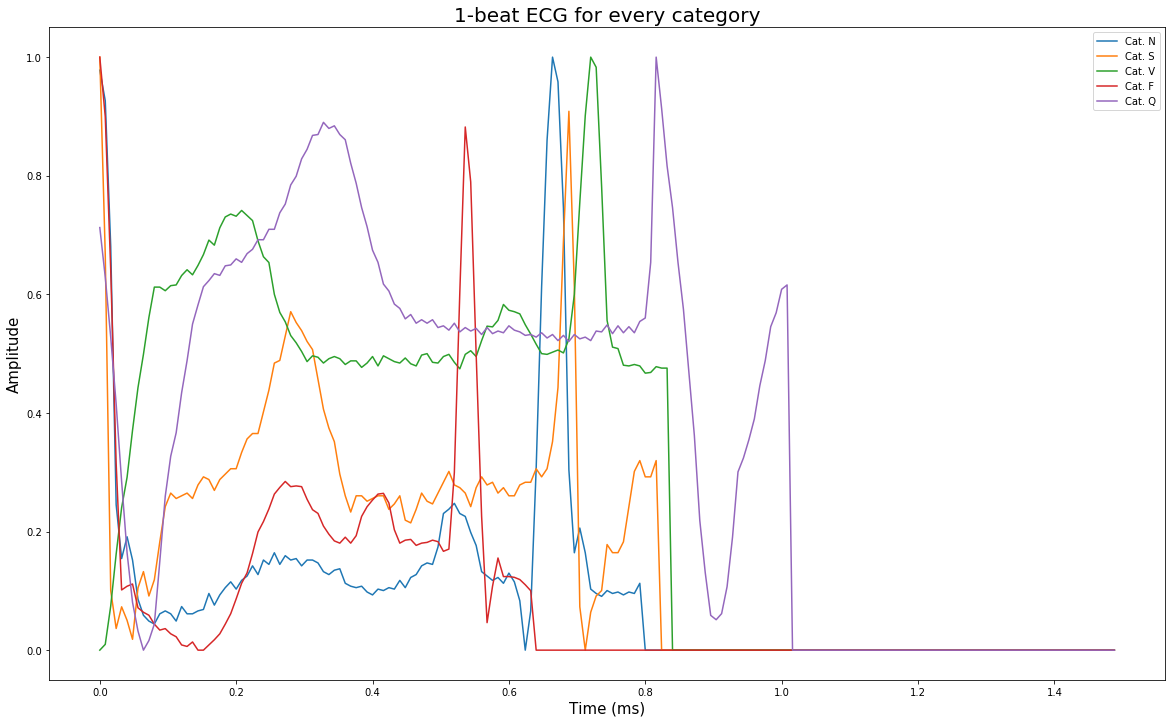

In [5]:
X = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))

plt.plot(X, x[C0, :][0], label="Cat. N")
plt.plot(X, x[C1, :][0], label="Cat. S")
plt.plot(X, x[C2, :][0], label="Cat. V")
plt.plot(X, x[C3, :][0], label="Cat. F")
plt.plot(X, x[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)

plt.show()

In [6]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

In [7]:
from scipy.signal import resample
result = np.apply_along_axis(augment, axis=1, arr=x[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
classe = np.reshape(classe,(6424,1))
x = np.vstack([x, result])
y = np.vstack([y, classe])

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

In [8]:
X_train, X_test, y_train, y_test =  train_test_split(x, y, test_size=0.2, random_state=42)
'''ohe = OneHotEncoder(categorical_features = [0])
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()'''

'ohe = OneHotEncoder(categorical_features = [0])\ny_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()\ny_test = ohe.transform(y_test.reshape(-1,1)).toarray()'

In [9]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn

In [10]:
class dataset(Dataset):
    def __init__(self,x,y):
        (n,f) = x.shape
        self.x = np.reshape(x,(n,1,f))
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        return torch.from_numpy(self.x[idx]),int(self.y[idx])

In [11]:
train_data = dataset(X_train,y_train)
train_loader = DataLoader(train_data, batch_size=1000)
test_data = dataset(X_test,y_test)
test_loader = DataLoader(test_data, batch_size=1000)

In [12]:
#model 1 cnn
class conv_model(nn.Module):
    def __init__(self):
        super(conv_model, self).__init__()
        self.c1 = nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 5, stride=1)
        self.c2 = nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = 5, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size = 5, stride = 2)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=False)
        self.linear1 = nn.Linear(4896,32)
        self.linear2 = nn.Linear(32,5)
        self.softmax = nn.LogSoftmax(dim = 1)
        self.dropout = nn.Dropout(p = 0.3)
    def forward(self, input):
        
        C = self.c1(input)
        C11 = self.c2(C)
        A11 = self.relu(C11)
        C12 = self.c2(A11)
        S11 = torch.cat((C12,C), dim = 2)
        A12 = self.relu(S11)
        M11 =  self.dropout(self.maxpool(A12))
        
        C21 = self.c2(M11)
        A21 = self.relu(C21)
        C22 = self.c2(A21)
        S21 = torch.cat((C22,M11), dim = 2)
        A22 = self.relu(S21)
        M21 =  self.dropout(self.maxpool(A22))
        
        C31 = self.c2(M21)
        A31 = self.relu(C31)
        C32 = self.c2(A31)
        S31 = torch.cat((C32,M21), dim = 2)
        A32 = self.relu(S31)
        M31 =  self.dropout(self.maxpool(A32))
        
        C41 = self.c2(M31)
        A41 = self.relu(C41)
        C42 = self.c2(A41)
        S41 = torch.cat((C42,M31), dim = 2)
        A42 = self.relu(S41)
        M41 = self.maxpool(A42)
        
        C51 = self.c2(M41)
        A51 = self.relu(C51)
        C52 = self.c2(A51)
        S51 = torch.cat((C52,M41), dim = 2)
        A52 = self.relu(S51)
        M51 =  self.maxpool(A52)
        
        F1 = M51.view(M51.size(0),-1)
        
        D1 = self.relu(self.linear1(F1))
        output = self.softmax(self.linear2(D1))
        return output

In [13]:
model1 = conv_model().to('cuda')
summary(model,(1,187))

NameError: name 'model' is not defined

In [14]:
import torch.optim as optim
# Loss -> Negative log likelihood loss
criterion = nn.NLLLoss()

In [15]:
def train(classifier,epoch,dataloader,batch_size,training = True , valid_loader = None):
    losses = []
    accuracy = []
    lr = 0.001
    if(training == False):
        epoch = 1
    for i in range(epoch):
        j=0
        running_corrects = 0
        running_loss=0
        optimizer = optim.Adam(classifier.parameters(), lr=lr)
        if(epoch%3==0):
            lr = lr/2
        if(epoch%20==0):
            lr = 0.001
        for batch_idx, (data, target) in enumerate(dataloader):
            if(training == False):
                classifier.eval()
            else:
                classifier.train()
            data, target = Variable(data), Variable(target)
            data = data.type(torch.cuda.FloatTensor)
            target = target.type(torch.cuda.LongTensor)
            optimizer.zero_grad()
            output = classifier(data)
            loss = criterion(output, target)
            if(training==True):
                loss.backward()
                optimizer.step()
            _, preds = torch.max(output, 1)
            running_corrects = running_corrects + torch.sum(preds == target.data)
            running_loss += loss.item() * data.size(0)
            j = j+1
            if(training == True):
                if batch_idx % 10 == 0:
                    print('Train Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(i, batch_idx * len(data), len(dataloader.dataset),100. * batch_idx / len(dataloader)
                                                                                             , running_loss/(j*1000),running_corrects.double()/(j*1000)))
        epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
        epoch_loss = running_loss/(len(dataloader)*batch_size)
        print('Acc {} Loss {}'.format(epoch_acc.item(),epoch_loss))
        losses.append(epoch_loss)
        accuracy.append(epoch_acc)
        if(valid_loader != None):
            train(classifier,1,valid_loader,1000 , training = False)
    return losses,accuracy

In [16]:
loss1,accuracy1 = train(model,75,train_loader,1000)

NameError: name 'model' is not defined

In [17]:
#model 1 cnn
class lstm_model(nn.Module):
    def __init__(self):
        super(lstm_model, self).__init__()
        self.lstm = nn.GRU(187,400,3)
        self.softmax = nn.LogSoftmax(dim = 1)
        self.linear1 = nn.Linear(400,100)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=False)
        self.linear2 = nn.Linear(100,5)
    def forward(self, input):
        output,_ = self.lstm(input)
        output = output.view(output.size(0),-1)
        x = self.relu(self.linear1(output))
        x = self.softmax(self.linear2(x))
        return x

In [18]:
model = lstm_model().to('cuda')
model

lstm_model(
  (lstm): GRU(187, 400, num_layers=3)
  (softmax): LogSoftmax()
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (linear2): Linear(in_features=100, out_features=5, bias=True)
)

In [19]:
model2 = nn.LSTM(187,100,3)

In [20]:
loss1,accuracy1 = train(model1,20,train_loader,1000 , valid_loader = test_loader)
#loss1,accuracy1 = train(model1,1,test_loader,1000,train = False)

NameError: name 'Variable' is not defined

In [21]:
input = torch.randn(1000, 1, 187)
input = input.to('cuda')
output = model(input)

In [22]:
input = torch.randn(1000, 1, 187)
o,(h,c) = model2(input)

In [23]:
o.shape

torch.Size([1000, 1, 100])